In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import yfinance as yf
import warnings
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('sp500_close.csv')

In [3]:
print(df.info())
print(df.describe())
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('D')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Columns: 506 entries, Unnamed: 0 to ZTS
dtypes: float64(505), object(1)
memory usage: 7.0+ MB
None
               AAL         AAPL          AAP        ABBV          ABC  \
count  1259.000000  1259.000000  1259.000000  1259.00000  1259.000000   
mean     38.393252   109.066698   132.433463    60.86444    82.092979   
std      10.957636    30.556812    31.274463    13.73038    16.315690   
min      13.020000    55.789900    76.180000    35.27000    46.180000   
25%      34.330000    84.830650   104.440000    52.65000    70.525000   
50%      40.870000   109.010000   141.300000    60.17000    82.560000   
75%      46.535000   127.120000   156.730000    65.74500    92.520000   
max      58.470000   179.260000   200.380000   123.21000   115.480000   

               ABT          ACN         ADBE          ADI          ADM  ...  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000  ...   
mean     42

Missing values in each column:
AAL     567
AAPL    567
AAP     567
ABBV    567
ABC     567
       ... 
XYL     567
YUM     567
ZBH     567
ZION    567
ZTS     567
Length: 505, dtype: int64


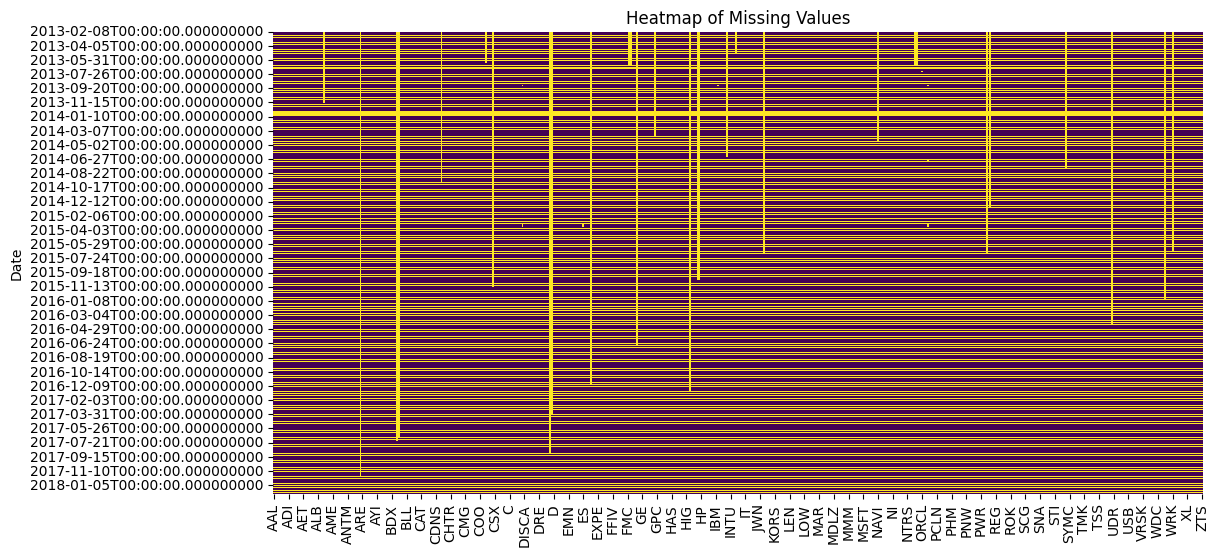

In [4]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

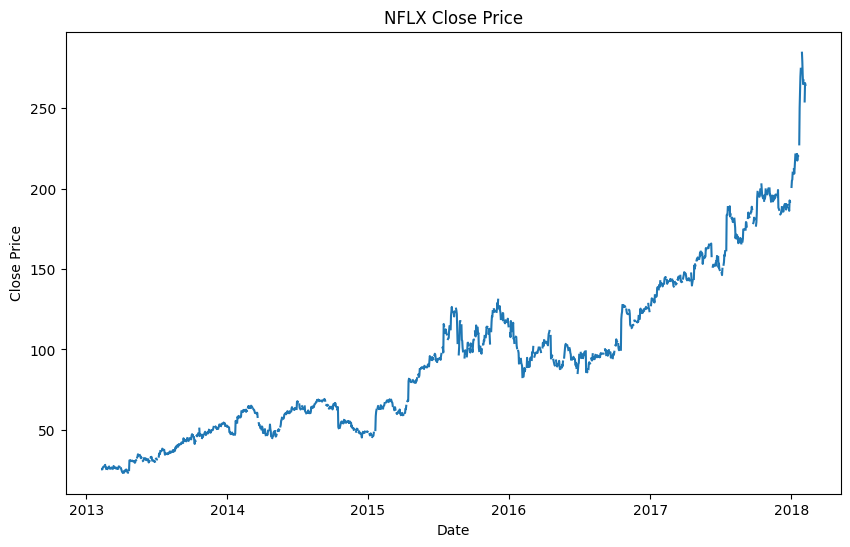

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(df['NFLX'])
plt.title('NFLX Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

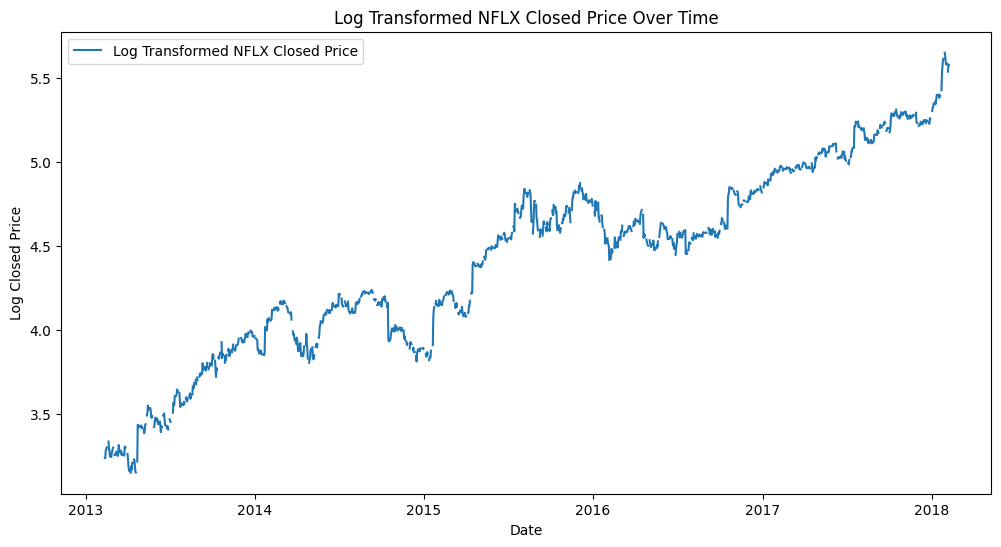

In [6]:
df['Log_NFLX'] = np.log(df['NFLX'])
plt.figure(figsize=(12, 6))
plt.plot(df['Log_NFLX'], label='Log Transformed NFLX Closed Price')
plt.title('Log Transformed NFLX Closed Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log Closed Price')
plt.legend()
plt.show()


Number of NaN values after filling: 0


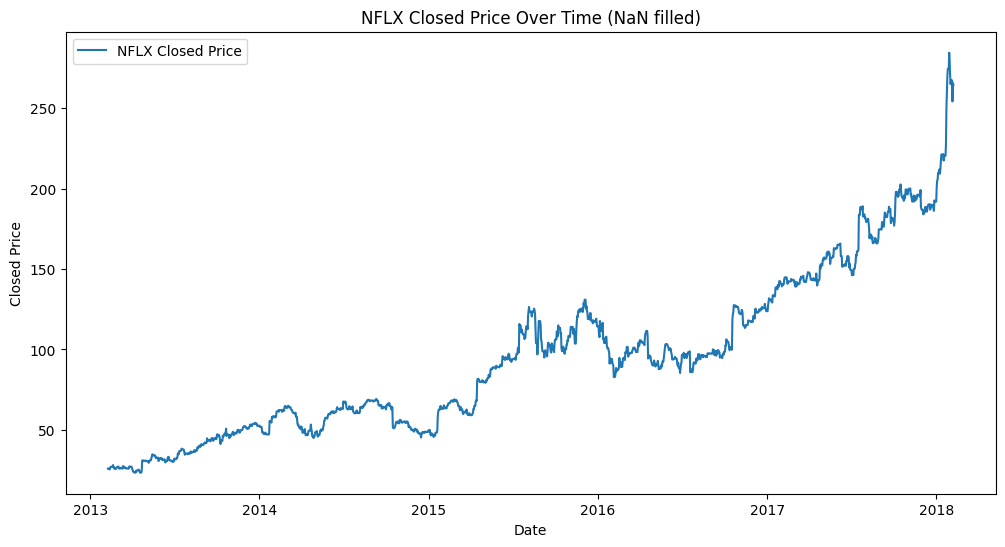

Missing values in each column:
Series([], dtype: int64)


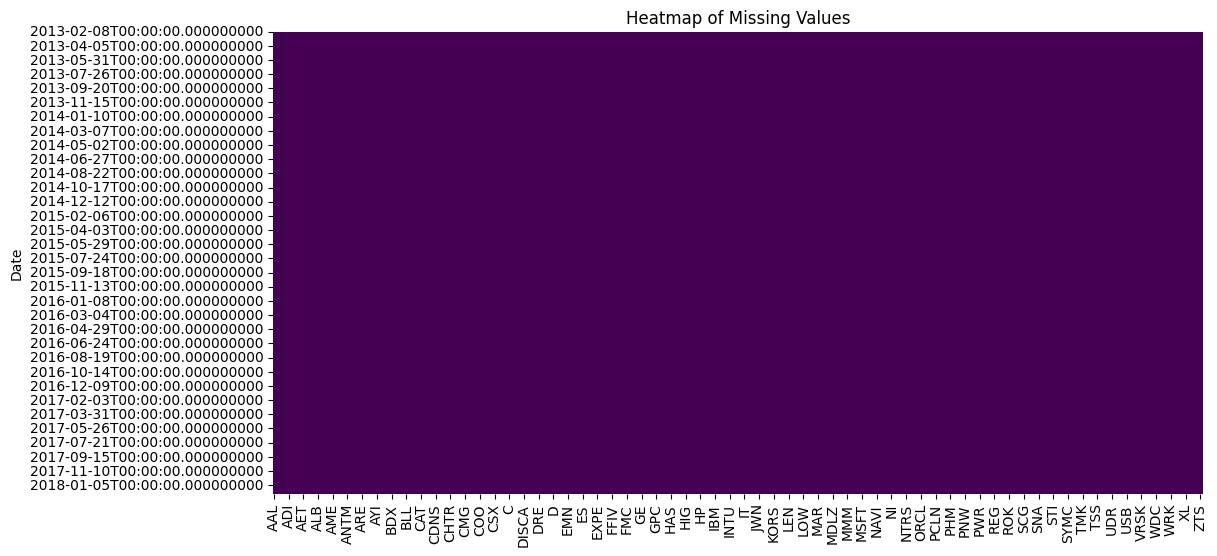

In [7]:
# Forward fill and backward fill missing values
df = df.ffill().bfill()

# Check if there are any remaining NaN values
print("Number of NaN values after filling:", df.isna().sum().sum())

# Plot the time series of a specific stock
plt.figure(figsize=(12, 6))
plt.plot(df['NFLX'], label='NFLX Closed Price')
plt.title('NFLX Closed Price Over Time (NaN filled)')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()
plt.show()

missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

In [8]:
df['Naive_Forecast'] = df['NFLX'].shift(1)

In [9]:
naive_rmse = root_mean_squared_error(df['NFLX'][1:], df['Naive_Forecast'][1:])
naive_mae = mean_absolute_error(df['NFLX'][1:], df['Naive_Forecast'][1:])

In [10]:
print(f"Naive RMSE: {naive_rmse}")
print(f"Naive MAE: {naive_mae}")

Naive RMSE: 2.188113216449277
Naive MAE: 1.0881563835616443


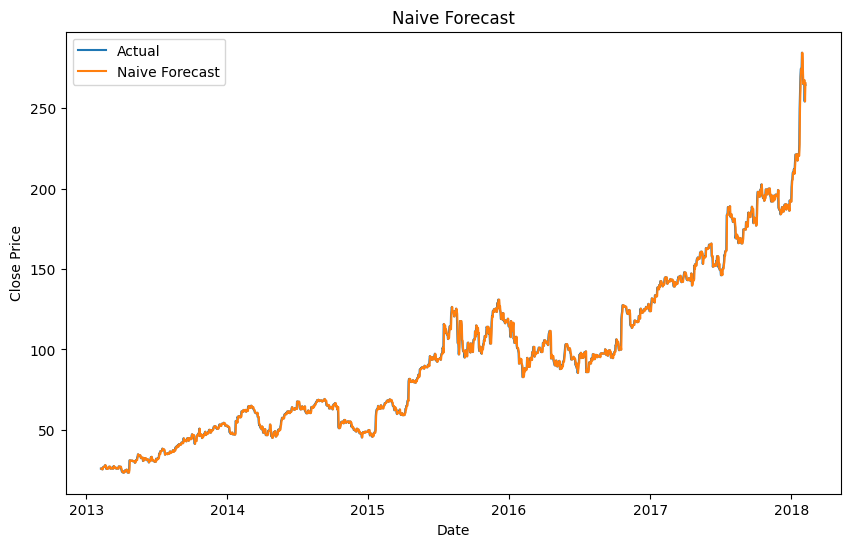

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(df['NFLX'], label='Actual')
plt.plot(df['Naive_Forecast'], label='Naive Forecast')
plt.title('Naive Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [12]:
window_size = 10
sma_forecast = df['NFLX'].rolling(window=window_size).mean()

In [13]:
rmse_sma = root_mean_squared_error(df['NFLX'][window_size:], sma_forecast[window_size:])
mae_sma = mean_absolute_error(df['NFLX'][window_size:], sma_forecast[window_size:])
print(f'SMA - RMSE: {rmse_sma}, MAE: {mae_sma}')

SMA - RMSE: 4.098761462258036, MAE: 2.476478843612335


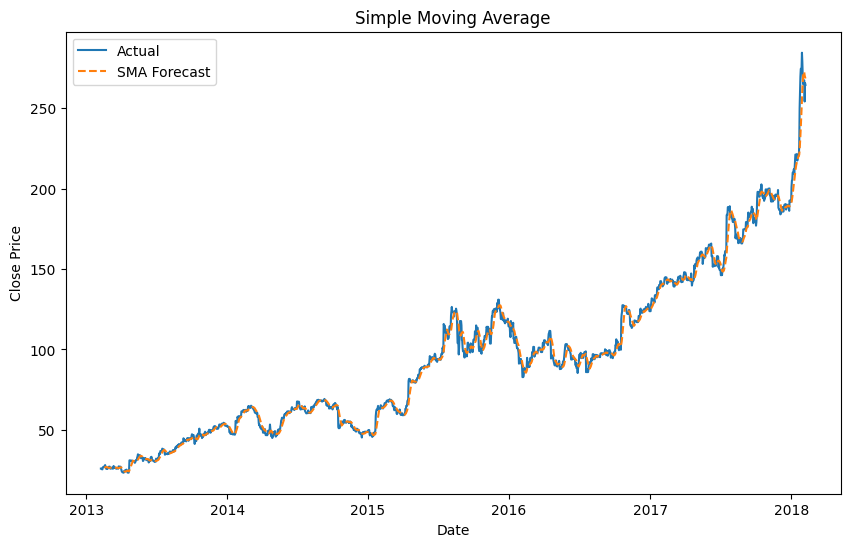

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df['NFLX'], label='Actual')
plt.plot(sma_forecast, label='SMA Forecast', linestyle='--')
plt.title('Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [15]:
ewma_forecast = df['NFLX'].ewm(span=10, adjust=False).mean()

In [16]:
mse_ewma = mean_squared_error(df['NFLX'], ewma_forecast)

In [17]:
rmse_ewma = np.sqrt(mse_ewma)

In [18]:
mae_ewma = mean_absolute_error(df['NFLX'], ewma_forecast)

print(f'EWMA - RMSE: {rmse_ewma}, MAE: {mae_ewma}')

EWMA - RMSE: 3.405377267725682, MAE: 2.0741593510263403


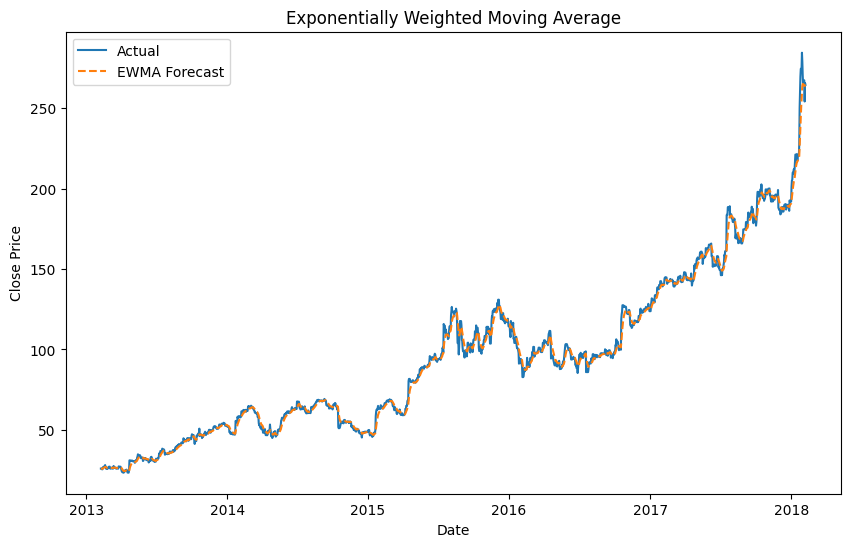

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(df['NFLX'], label='Actual')
plt.plot(ewma_forecast, label='EWMA Forecast', linestyle='--')
plt.title('Exponentially Weighted Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [20]:
holt_additive = ExponentialSmoothing(df['NFLX'], seasonal='add', seasonal_periods=365).fit()
holt_additive_forecast = holt_additive.fittedvalues

In [21]:
rmse_holt_add = np.sqrt(mean_squared_error(df['NFLX'], holt_additive_forecast))
mae_holt_add = mean_absolute_error(df['NFLX'], holt_additive_forecast)
print(f'Holt-Winters Additive - RMSE: {rmse_holt_add}, MAE: {mae_holt_add}')

Holt-Winters Additive - RMSE: 1.9559219747267105, MAE: 1.2192993891010815


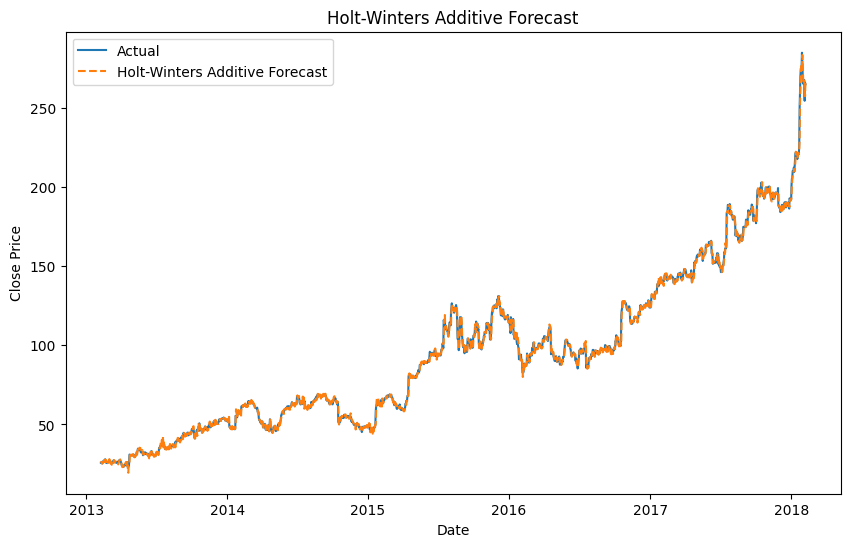

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(df['NFLX'], label='Actual')
plt.plot(holt_additive_forecast, label='Holt-Winters Additive Forecast', linestyle='--')
plt.title('Holt-Winters Additive Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [23]:
holt_multiplicative = ExponentialSmoothing(df['NFLX'], seasonal='mul', seasonal_periods=365).fit()
holt_multiplicative_forecast = holt_multiplicative.fittedvalues


In [24]:
rmse_holt_mul = mean_squared_error(df['NFLX'], holt_multiplicative_forecast)
mae_holt_mul = mean_absolute_error(df['NFLX'], holt_multiplicative_forecast)
print(f'Holt-Winters Multiplicative - RMSE: {rmse_holt_mul}, MAE: {mae_holt_mul}')

Holt-Winters Multiplicative - RMSE: 3.371525508677163, MAE: 1.147685541931465


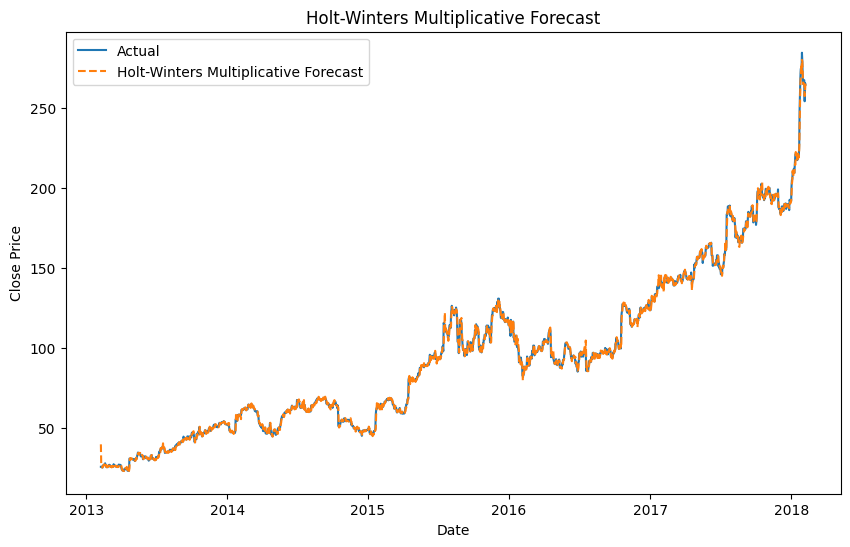

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(df['NFLX'], label='Actual')
plt.plot(holt_multiplicative_forecast, label='Holt-Winters Multiplicative Forecast', linestyle='--')
plt.title('Holt-Winters Multiplicative Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

ADF Statistic: 1.61385403607834
p-value: 0.9978985497118823
Critical Values:
   1%: -3.4339520666978056
   5%: -2.8631311116872475
   10%: -2.567617054512932
ADF Statistic (after differencing): -15.486161452461896
p-value (after differencing): 2.51921902514215e-28
Critical Values (after differencing):
   1%: -3.4339540519343137
   5%: -2.863131988080628
   10%: -2.5676175211639354


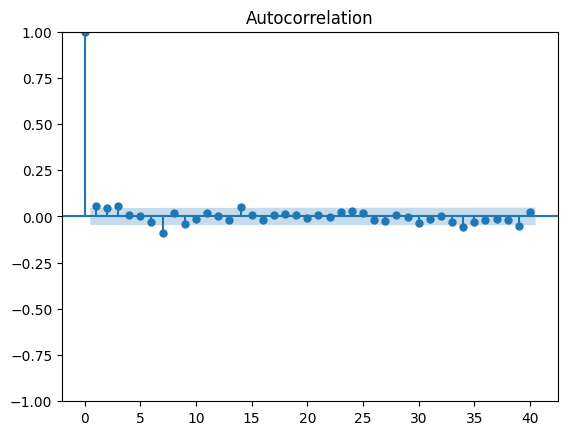

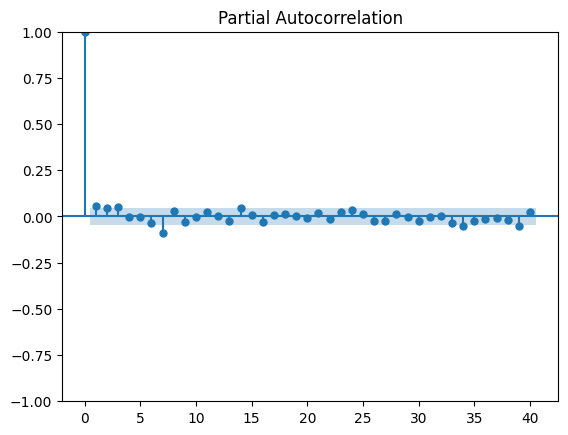

ARIMA Model - RMSE: 2.1746809028870815, MAE: 1.1337767483898358


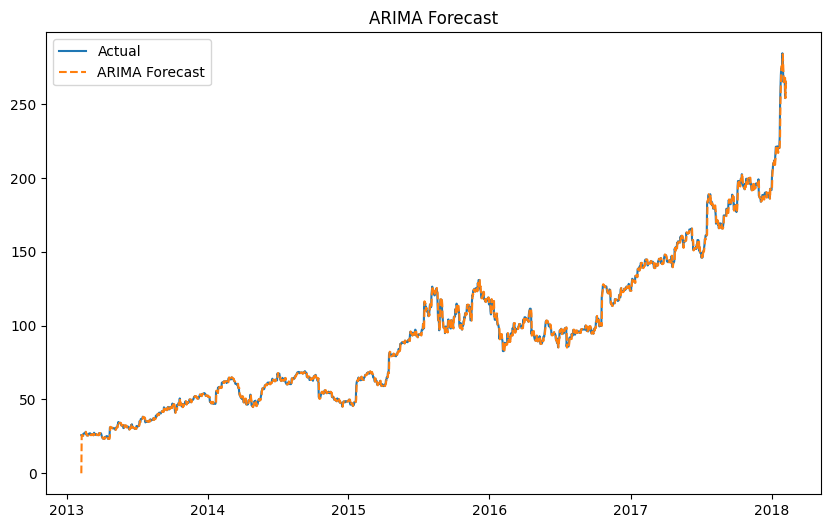

In [30]:
# ADF Test to check stationarity
result = adfuller(df['NFLX'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# If p-value > 0.05, difference the series
if result[1] > 0.05:
    df['Diff_Close'] = df['NFLX'].diff().dropna()
    result_diff = adfuller(df['Diff_Close'].dropna())
    print(f'ADF Statistic (after differencing): {result_diff[0]}')
    print(f'p-value (after differencing): {result_diff[1]}')
    print('Critical Values (after differencing):')
    for key, value in result_diff[4].items():
        print(f'   {key}: {value}')
    d = 1
else:
    d = 0

# ACF and PACF plots to determine p and q
if d == 1:
    series_to_use = df['Diff_Close'].dropna()
else:
    series_to_use = df['NFLX']

plot_acf(series_to_use, lags=40)
plot_pacf(series_to_use, lags=40)
plt.show()

# Set p, d, q values based on ACF, PACF, and differencing results
p, q = 2, 2  # Example values, change based on your analysis

# Fit ARIMA model
arima_model = ARIMA(df['NFLX'], order=(p,d,q)).fit()
arima_forecast = arima_model.fittedvalues

# Evaluate the model
rmse_arima = mean_squared_error(df['NFLX'][d:], arima_forecast[d:], squared=False)
mae_arima = mean_absolute_error(df['NFLX'][d:], arima_forecast[d:])

print(f'ARIMA Model - RMSE: {rmse_arima}, MAE: {mae_arima}')

# Plot ARIMA Forecast
plt.figure(figsize=(10,6))
plt.plot(df['NFLX'], label='Actual')
plt.plot(arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()


[*********************100%%**********************]  1 of 1 completed
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66367D+00    |proj g|=  1.51038D-01

At iterate    5    f=  1.65184D+00    |proj g|=  1.59691D-01

At iterate   10    f=  1.64967D+00    |proj g|=  7.50330D-03

At iterate   15    f=  1.64967D+00    |proj g|=  1.02034D-02

At iterate   20    f=  1.64945D+00    |proj g|=  1.80780D-01

At iterate   25    f=  1.64823D+00    |proj g|=  8.75808D-03

At iterate   30    f=  1.64802D+00    |proj g|=  3.44121D-02

At iterate   35    f=  1.64801D+00    |proj g|=  1.02285D-03

At iterate   40    f=  1.64801D+00    |proj g|=  2.10871D-02

At iterate   45    f=  1.64799D+00    |proj g|=  1.30747D-02

At iterate   50    f=  1.64796D+00    |proj g|=  7.96961D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

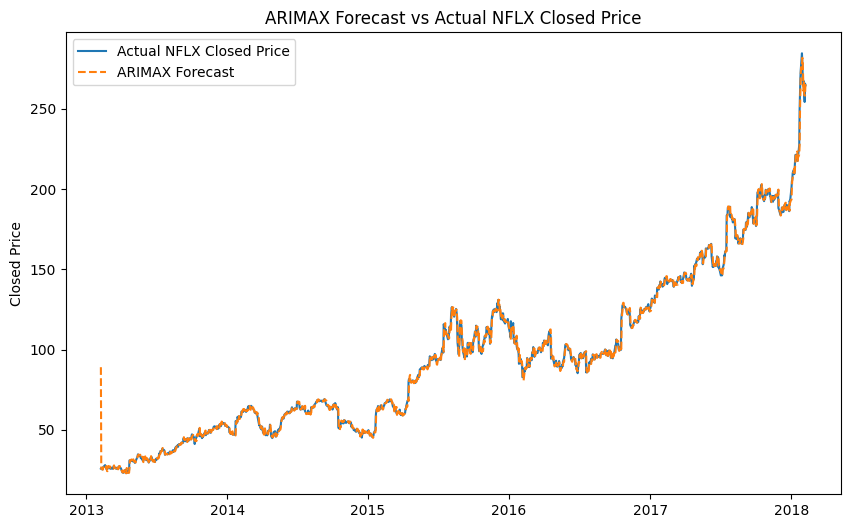

In [27]:

#Load data
data = pd.read_csv('sp500_close.csv', index_col=0, parse_dates=True)

#Load DJIA data
djia_data = yf.download('^DJI', start=data.index.min(), end=data.index.max())['Adj Close']
djia_data = djia_data.interpolate(method='linear')  # Interpolate missing values
djia_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
djia_data.dropna(inplace=True)  # Drop rows with NaN after replacing inf

#Ensure the index alignment
djia_data = djia_data.reindex(data.index, method='nearest')  # Reindex to match 'data'

#Add DJIA to 'data'
data['DJIA'] = djia_data

#Define the order (p, d, q)
p = 2
d = 1
q = 2

#Create exogenous data
exog_data = data[['DJIA']]

#Fit SARIMAX model
arimax_model = SARIMAX(data['NFLX'], order=(p, d, q), exog=exog_data).fit()

#Forecast using the ARIMAX model
arimax_forecast = arimax_model.predict(start=data.index.min(), end=data.index.max(), exog=exog_data)

#Interpolate missing values in NFLX
data['NFLX'].interpolate(inplace=True)

#Calculate RMSE and MAE
arimax_rmse = np.sqrt(mean_squared_error(data['NFLX'][d:], arimax_forecast[d:]))
arimax_mae = mean_absolute_error(data['NFLX'][d:], arimax_forecast[d:])

print(f'ARIMAX Model RMSE: {arimax_rmse}')
print(f'ARIMAX Model MAE: {arimax_mae}')

#Plot the forecasts and compare with actual data
plt.figure(figsize=(10, 6))
plt.plot(data['NFLX'], label='Actual NFLX Closed Price')
plt.plot(arimax_forecast, label='ARIMAX Forecast', linestyle='--')
plt.title('ARIMAX Forecast vs Actual NFLX Closed Price')
plt.ylabel('Closed Price')
plt.legend()
plt.show()

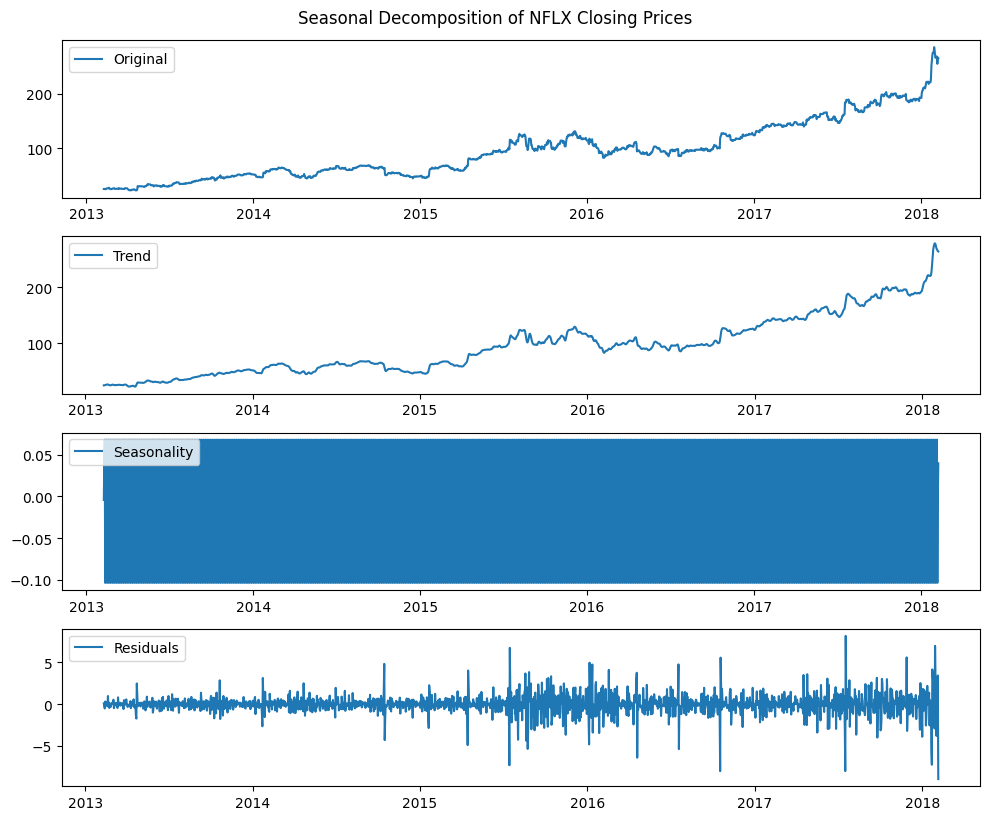

<Figure size 1000x600 with 0 Axes>

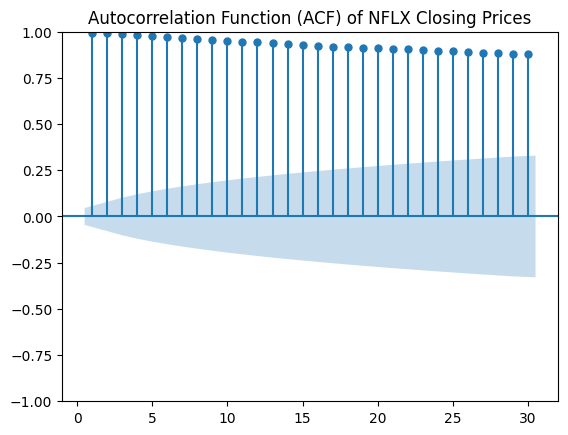

<Figure size 1000x600 with 0 Axes>

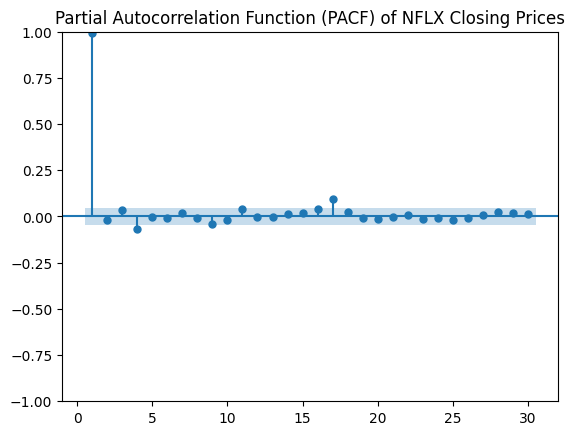

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=8021.427, Time=2.03 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=8034.687, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=8032.250, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=8032.748, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=8039.220, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=8023.119, Time=1.53 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=8023.071, Time=1.06 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=8020.185, Time=3.35 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=8018.683, Time=2.47 sec
 ARIMA(1,1,2)(2,0,0)[4] intercept   : AIC=8030.814, Time=0.71 sec
 ARIMA(2,1,1)(2,0,0)[4] intercept   : AIC=8030.973, Time=1.02 sec
 ARIMA(3,1,2)(2,0,0)[4] intercept   : AIC=8022.659, Time=3.46 sec
 ARIMA(2,1,3)(2,0,0)[4] intercept   : AIC=8020.329, Time=1.98 sec
 ARIMA(1,1,1)(2,0,0)[4] intercept   : AIC=8029.842, Time=1.28 sec
 ARIMA(1,1,3)(2,0,0)[4] intercept

 This problem is unconstrained.



At iterate   10    f=  2.19658D+00    |proj g|=  8.20312D-04

At iterate   15    f=  2.19647D+00    |proj g|=  8.94132D-03

At iterate   20    f=  2.19460D+00    |proj g|=  2.10835D-02

At iterate   25    f=  2.19285D+00    |proj g|=  2.92330D-03

At iterate   30    f=  2.19265D+00    |proj g|=  2.13674D-03

At iterate   35    f=  2.19259D+00    |proj g|=  2.23084D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     47      1     0     0   3.205D-05   2.193D+00
  F =   2.1925918258525265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model MSE: 4.7099009583483475
SARIMA Model R

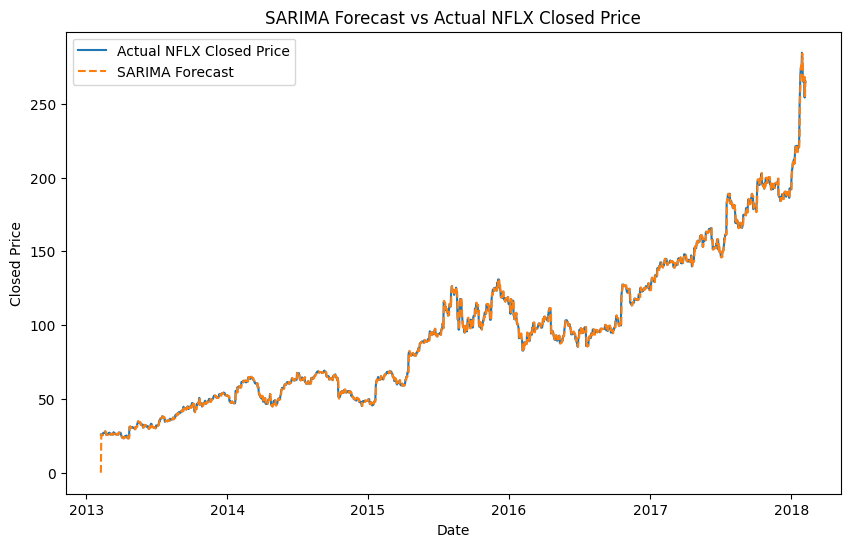

In [28]:
# Load your data (assuming quarterly data for NFLX)
df = pd.read_csv('sp500_close.csv', index_col=0, parse_dates=True)
df = df.ffill().bfill()
nflx = df['NFLX']

# Seasonal decomposition
decomposition = seasonal_decompose(nflx, model='additive', period=4)  # Assuming quarterly data
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

# Plot seasonal decomposition
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(nflx, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residuals, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.suptitle('Seasonal Decomposition of NFLX Closing Prices', y=1.02)
plt.show()

# ACF and PACF analysis
plt.figure(figsize=(10, 6))
plot_acf(nflx, lags=30, zero=False)
plt.title('Autocorrelation Function (ACF) of NFLX Closing Prices')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(nflx, lags=30, zero=False)
plt.title('Partial Autocorrelation Function (PACF) of NFLX Closing Prices')
plt.show()

# Use auto_arima to find the best SARIMA parameters
sarima_model = auto_arima(nflx, seasonal=True, m=4, trace=True, stepwise=True, suppress_warnings=True)

# Print the identified parameters
print(f"Identified SARIMA parameters: {sarima_model.order} and seasonal order: {sarima_model.seasonal_order}")

# Extract the best SARIMA parameters
order = sarima_model.order
seasonal_order = sarima_model.seasonal_order

# Fit the SARIMA model
sarima_fitted = SARIMAX(nflx, order=order, seasonal_order=seasonal_order).fit()

# Forecast the values
sarima_forecast = sarima_fitted.fittedvalues

# Evaluate the model's performance
sarima_mse = mean_squared_error(nflx[1:], sarima_forecast[1:])
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(nflx[1:], sarima_forecast[1:])

print(f'SARIMA Model MSE: {sarima_mse}')
print(f'SARIMA Model RMSE: {sarima_rmse}')
print(f'SARIMA Model MAE: {sarima_mae}')

# Plot the forecasts and compare them with the actual data
plt.figure(figsize=(10, 6))
plt.plot(nflx, label='Actual NFLX Closed Price')
plt.plot(sarima_forecast, label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA Forecast vs Actual NFLX Closed Price')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=8021.427, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=8034.687, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=8032.250, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=8032.748, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=8039.220, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=8023.119, Time=1.58 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=8023.071, Time=1.07 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=8020.185, Time=3.35 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=8018.683, Time=2.45 sec
 ARIMA(1,1,2)(2,0,0)[4] intercept   : AIC=8030.814, Time=0.71 sec
 ARIMA(2,1,1)(2,0,0)[4] intercept   : AIC=8030.973, Time=1.01 sec
 ARIMA(3,1,2)(2,0,0)[4] intercept   : AIC=8022.659, Time=3.42 sec
 ARIMA(2,1,3)(2,0,0)[4] intercept   : AIC=8020.329, Time=2.09 sec
 ARIMA(1,1,1)(2,0,0)[4] intercept   : AIC=8029.842, Time=1.35 sec
 ARIMA(1,1,3)(2,0,0)[4] intercept

 This problem is unconstrained.



At iterate    5    f=  2.15808D+00    |proj g|=  2.59366D-01

At iterate   10    f=  2.15794D+00    |proj g|=  1.76973D-02

At iterate   15    f=  2.15790D+00    |proj g|=  2.19071D-01

At iterate   20    f=  2.15779D+00    |proj g|=  1.04806D-02

At iterate   25    f=  2.15773D+00    |proj g|=  3.30031D-02

At iterate   30    f=  2.15744D+00    |proj g|=  1.14914D-01

At iterate   35    f=  2.15733D+00    |proj g|=  2.15461D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     56      1     0     0   6.815D-04   2.157D+00
  F =   2.1573308887450491     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMAX Model MSE: 4.592310539073453
SARIMAX Model RMSE: 2.1429676943606624
SARIMAX Model MAE: 1.12497887734234


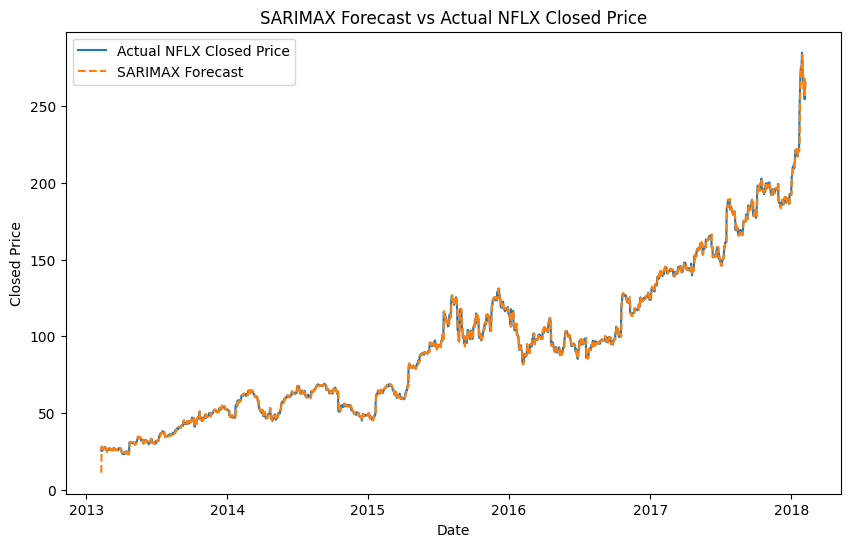

In [29]:
# Load your data (assuming quarterly data for NFLX)
df = pd.read_csv('sp500_close.csv', index_col=0, parse_dates=True)
df = df.ffill().bfill()
nflx = df['NFLX']

# Seasonal decomposition
decomposition = seasonal_decompose(nflx, model='additive', period=4)  # Assuming quarterly data
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

# Use auto_arima to find the best SARIMA parameters
sarima_model = auto_arima(nflx, seasonal=True, m=4, trace=True, stepwise=True, suppress_warnings=True)

# Print the identified parameters
print(f"Identified SARIMA parameters: {sarima_model.order} and seasonal order: {sarima_model.seasonal_order}")

# Extract the best SARIMA parameters
order = sarima_model.order
seasonal_order = sarima_model.seasonal_order

# Fit the SARIMAX model
sarimax_model = SARIMAX(nflx, exog=djia_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_fitted = sarimax_model.fit()

# Forecast the values
sarimax_forecast = sarimax_fitted.predict(start=1, end=len(nflx)-1, dynamic=False)

# Evaluate the model's performance
sarimax_mse = mean_squared_error(nflx[1:], sarimax_forecast)
sarimax_rmse = np.sqrt(sarimax_mse)
sarimax_mae = mean_absolute_error(nflx[1:], sarimax_forecast)

print(f'SARIMAX Model MSE: {sarimax_mse}')
print(f'SARIMAX Model RMSE: {sarimax_rmse}')
print(f'SARIMAX Model MAE: {sarimax_mae}')

# Plot the forecasts and compare them with the actual data
plt.figure(figsize=(10, 6))
plt.plot(nflx, label='Actual NFLX Closed Price')
plt.plot(sarimax_forecast, label='SARIMAX Forecast', linestyle='--')
plt.title('SARIMAX Forecast vs Actual NFLX Closed Price')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()
plt.show()
